# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from model import ImageMamba, ModelArgs, SmallerComparableCNN
from data_loader import load_cifar10
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import json
from tqdm import tqdm

from data_loader import load_cifar10, get_class_names
import gc

# Code

In [2]:
def load_all_checkpoints(checkpoint_dir, model, device='cuda'):
    """Load all available checkpoints for a model."""
    checkpoints = []
    epochs = []
    
    for filename in os.listdir(checkpoint_dir):
        if filename.endswith('.pt'):
            epoch = int(filename.split('_')[-1].split('.pt')[0])
            checkpoint_path = os.path.join(checkpoint_dir, filename)
            checkpoint = torch.load(checkpoint_path, map_location=device)
            model.load_state_dict(checkpoint['model_state_dict'])
            
            checkpoints.append({
                'epoch': epoch,
                'model_state': model.state_dict(),
                'metrics': checkpoint['metrics'] if 'metrics' in checkpoint else None
            })
            epochs.append(epoch)
    
    return sorted(checkpoints, key=lambda x: x['epoch']), sorted(epochs)

def evaluate_model_vulnerability(model, train_loader, test_loader, device='cuda'):
    """Evaluate model's vulnerability to inference attacks."""
    model.eval()
    
    def get_confidence_stats(loader):
        confidences = []
        predictions = []
        with torch.no_grad():
            for data, labels in loader:
                data = data.to(device)
                _, probs = model(data)
                max_probs, preds = torch.max(probs, dim=1)
                confidences.extend(max_probs.cpu().numpy())
                predictions.extend((preds == labels.to(device)).cpu().numpy())
        return np.mean(confidences), np.std(confidences), np.mean(predictions)

    train_conf_mean, train_conf_std, train_acc = get_confidence_stats(train_loader)
    test_conf_mean, test_conf_std, test_acc = get_confidence_stats(test_loader)
    
    # Calculate vulnerability metrics
    confidence_gap = train_conf_mean - test_conf_mean
    acc_gap = train_acc - test_acc
    
    # Calculate confidence distribution overlap
    confidence_overlap = min(train_conf_mean + train_conf_std, test_conf_mean + test_conf_std) - \
                        max(train_conf_mean - train_conf_std, test_conf_mean - test_conf_std)
    
    return {
        'train_confidence': train_conf_mean,
        'test_confidence': test_conf_mean,
        'train_accuracy': train_acc * 100,
        'test_accuracy': test_acc * 100,
        'confidence_gap': confidence_gap,
        'accuracy_gap': acc_gap * 100,
        'confidence_overlap': confidence_overlap
    }

def analyze_models(mamba_model, cnn_model, train_loader, test_loader, mamba_dir, cnn_dir, device='cuda'):
    """Analyze both models across their checkpoints."""
    
    # Load checkpoints
    print("Loading MAMBA checkpoints...")
    mamba_checkpoints, mamba_epochs = load_all_checkpoints(mamba_dir, mamba_model, device)
    print("Loading CNN checkpoints...")
    cnn_checkpoints, cnn_epochs = load_all_checkpoints(cnn_dir, cnn_model, device)
    
    results = {
        'mamba': {'vulnerabilities': [], 'epochs': mamba_epochs},
        'cnn': {'vulnerabilities': [], 'epochs': cnn_epochs}
    }
    
    # Analyze MAMBA checkpoints
    print("\nAnalyzing MAMBA checkpoints...")
    for checkpoint in tqdm(mamba_checkpoints):
        mamba_model.load_state_dict(checkpoint['model_state'])
        vuln = evaluate_model_vulnerability(mamba_model, train_loader, test_loader, device)
        results['mamba']['vulnerabilities'].append(vuln)
    
    # Analyze CNN checkpoints
    print("\nAnalyzing CNN checkpoints...")
    for checkpoint in tqdm(cnn_checkpoints):
        cnn_model.load_state_dict(checkpoint['model_state'])
        vuln = evaluate_model_vulnerability(cnn_model, train_loader, test_loader, device)
        results['cnn']['vulnerabilities'].append(vuln)
    
    return results
    \

In [11]:
def analyze_models_memory_efficient(mamba_model, cnn_model, train_loader, test_loader, 
                                 mamba_dir, cnn_dir, device='cuda'):
    """Memory efficient version of model analysis."""
    
    def get_checkpoint_epochs(checkpoint_dir):
        """Get sorted list of epoch numbers from checkpoint directory."""
        epochs = []
        for filename in os.listdir(checkpoint_dir):
            if filename.endswith('.pt'):
                epoch = int(filename.split('_')[-1].split('.pt')[0])
                epochs.append(epoch)
        return sorted(epochs)
    
    def evaluate_single_checkpoint(model, checkpoint_path, train_loader, test_loader, device):
        """Evaluate a single checkpoint and free memory."""
        # Load checkpoint
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        
        # Evaluate
        vuln_metrics = evaluate_model_vulnerability(model, train_loader, test_loader, device)
        
        # Clear memory
        del checkpoint
        torch.cuda.empty_cache()
        gc.collect()
        
        return vuln_metrics
    
    # Get epochs for each model
    print("Finding checkpoints...")
    mamba_epochs = get_checkpoint_epochs(mamba_dir)
    cnn_epochs = get_checkpoint_epochs(cnn_dir)
    
    results = {
        'mamba': {'vulnerabilities': [], 'epochs': mamba_epochs},
        'cnn': {'vulnerabilities': [], 'epochs': cnn_epochs}
    }
    
    # Analyze MAMBA checkpoints
    print("\nAnalyzing MAMBA checkpoints...")
    for epoch in tqdm(mamba_epochs):
        checkpoint_path = os.path.join(mamba_dir, f'model_epoch_{epoch}.pt')
        vuln = evaluate_single_checkpoint(mamba_model, checkpoint_path, 
                                        train_loader, test_loader, device)
        results['mamba']['vulnerabilities'].append(vuln)
        gc.collect()
    
    # Analyze CNN checkpoints
    print("\nAnalyzing CNN checkpoints...")
    for epoch in tqdm(cnn_epochs):
        checkpoint_path = os.path.join(cnn_dir, f'cnn_model_epoch_{epoch}.pt')
        vuln = evaluate_single_checkpoint(cnn_model, checkpoint_path, 
                                        train_loader, test_loader, device)
        results['cnn']['vulnerabilities'].append(vuln)
        gc.collect()
    
    return results

def evaluate_model_vulnerability(model, train_loader, test_loader, device='cuda'):
    """Evaluate model's vulnerability to inference attacks with memory efficiency."""
    model.eval()
    
def plot_vulnerability_comparison(results, save_dir='comparison_plots'):
    """Plot comparison of model vulnerabilities with proper line connectivity."""
    os.makedirs(save_dir, exist_ok=True)
    
    # Sort results by epoch to ensure proper line connectivity
    mamba_data = sorted(zip(results['mamba']['epochs'], 
                           results['mamba']['vulnerabilities']), 
                       key=lambda x: x[0])
    cnn_data = sorted(zip(results['cnn']['epochs'], 
                         results['cnn']['vulnerabilities']), 
                     key=lambda x: x[0])
    
    # Unzip the sorted data
    mamba_epochs, mamba_vulns = zip(*mamba_data)
    cnn_epochs, cnn_vulns = zip(*cnn_data)
    
    # Create figure
    fig = plt.figure(figsize=(20, 15))
    gs = plt.GridSpec(3, 2)
    
    # 1. Accuracy Gaps
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(mamba_epochs, 
             [v['accuracy_gap'] for v in mamba_vulns], 
             'b-', label='MAMBA', linewidth=2)
    ax1.plot(cnn_epochs, 
             [v['accuracy_gap'] for v in cnn_vulns], 
             'r-', label='CNN', linewidth=2)
    ax1.set_title('Train-Test Accuracy Gap Evolution')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy Gap (%)')
    ax1.legend()
    ax1.grid(True)
    
    # 2. Confidence Gaps
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(mamba_epochs, 
             [v['confidence_gap'] for v in mamba_vulns], 
             'b-', label='MAMBA', linewidth=2)
    ax2.plot(cnn_epochs, 
             [v['confidence_gap'] for v in cnn_vulns], 
             'r-', label='CNN', linewidth=2)
    ax2.set_title('Confidence Gap Evolution')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Train-Test Confidence Gap')
    ax2.legend()
    ax2.grid(True)
    
    # 3. Train vs Test Accuracies
    ax3 = fig.add_subplot(gs[1, :])
    ax3.plot(mamba_epochs, 
             [v['train_accuracy'] for v in mamba_vulns], 
             'b-', label='MAMBA Train', linewidth=2)
    ax3.plot(mamba_epochs, 
             [v['test_accuracy'] for v in mamba_vulns], 
             'b--', label='MAMBA Test', linewidth=2)
    ax3.plot(cnn_epochs, 
             [v['train_accuracy'] for v in cnn_vulns], 
             'r-', label='CNN Train', linewidth=2)
    ax3.plot(cnn_epochs, 
             [v['test_accuracy'] for v in cnn_vulns], 
             'r--', label='CNN Test', linewidth=2)
    ax3.set_title('Accuracy Comparison')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Accuracy (%)')
    ax3.legend()
    ax3.grid(True)
    
    # 4. Vulnerability Score Evolution
    ax4 = fig.add_subplot(gs[2, :])
    mamba_scores = [v['confidence_gap'] * (1 - v['confidence_overlap']) 
                   for v in mamba_vulns]
    cnn_scores = [v['confidence_gap'] * (1 - v['confidence_overlap']) 
                  for v in cnn_vulns]
    
    ax4.plot(mamba_epochs, mamba_scores, 'b-', label='MAMBA', linewidth=2)
    ax4.plot(cnn_epochs, cnn_scores, 'r-', label='CNN', linewidth=2)
    ax4.set_title('Overall Vulnerability Score Evolution')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Vulnerability Score')
    ax4.legend()
    ax4.grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'vulnerability_analysis.png'))
    
    # Print summary statistics
    print("\nVulnerability Analysis Summary:")
    print("="*50)
    
    final_mamba = mamba_vulns[-1]
    final_cnn = cnn_vulns[-1]
    
    print(f"\nFinal Checkpoint Statistics:")
    print(f"MAMBA (Epoch {mamba_epochs[-1]}):")
    print(f"  - Accuracy Gap: {final_mamba['accuracy_gap']:.2f}%")
    print(f"  - Confidence Gap: {final_mamba['confidence_gap']:.4f}")
    print(f"  - Train Accuracy: {final_mamba['train_accuracy']:.2f}%")
    print(f"  - Test Accuracy: {final_mamba['test_accuracy']:.2f}%")
    
    print(f"\nCNN (Epoch {cnn_epochs[-1]}):")
    print(f"  - Accuracy Gap: {final_cnn['accuracy_gap']:.2f}%")
    print(f"  - Confidence Gap: {final_cnn['confidence_gap']:.4f}")
    print(f"  - Train Accuracy: {final_cnn['train_accuracy']:.2f}%")
    print(f"  - Test Accuracy: {final_cnn['test_accuracy']:.2f}%")
    
    # Calculate overall vulnerability scores
    mamba_vuln_score = mamba_scores[-1]
    cnn_vuln_score = cnn_scores[-1]
    
    print(f"\nOverall Vulnerability Score (higher = more vulnerable):")
    print(f"MAMBA: {mamba_vuln_score:.4f}")
    print(f"CNN: {cnn_vuln_score:.4f}")
    
    conclusion = "MAMBA" if mamba_vuln_score > cnn_vuln_score else "CNN"
    print(f"\nConclusion: {conclusion} appears more vulnerable to inference attacks.")
    
    return fig

# Run

In [12]:
# Initialize models
d_model = 128  # As used in mamba training
n_layer = 8    # As used in mamba training
num_classes = 10

model_args = ModelArgs(d_model=d_model, n_layer=n_layer, vocab_size=0)
mamba_model = ImageMamba(model_args, num_classes=num_classes)
cnn_model = SmallerComparableCNN()  # Uses fixed architecture

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mamba_model = mamba_model.to(device)
cnn_model = cnn_model.to(device)

In [13]:
train_loader, test_loader, _, _, _, _ = load_cifar10(batch_size=64, seed=42)
class_names = get_class_names()

Files already downloaded and verified
Files already downloaded and verified


Starting analysis...
Initializing models...

Analyzing MAMBA model...


Analyzing MAMBA:   0%|          | 0/12 [00:00<?, ?it/s]C:\Users\baris\AppData\Local\Temp\ipykernel_12032\2657652263.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chec

Error processing checkpoint model_epoch_1200.pt: PytorchStreamReader failed locating file data.pkl: file not found


Analyzing MAMBA: 100%|██████████| 12/12 [49:54<00:00, 249.53s/it]



Analyzing CNN model...


Analyzing CNN: 100%|██████████| 9/9 [23:43<00:00, 158.21s/it]

Error processing checkpoint model_epoch_900.pt: PytorchStreamReader failed reading zip archive: failed finding central directory

Creating plots...
Error during execution: 'NoneType' object is not subscriptable


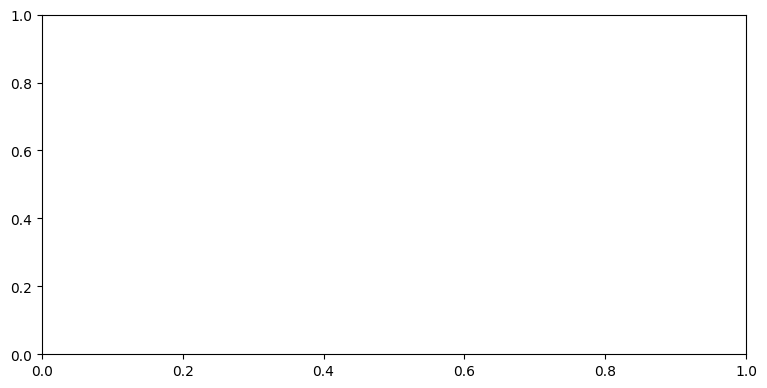

In [14]:
def analyze_single_model(model, checkpoint_dir, train_loader, test_loader, device='cuda', model_name=''):
    """Analyze a single model's checkpoints one at a time with memory safeguards."""
    epochs = []
    vulnerabilities = []
    
    # Get sorted list of checkpoints
    checkpoints = sorted([f for f in os.listdir(checkpoint_dir) if f.endswith('.pt')])
    
    for checkpoint_file in tqdm(checkpoints, desc=f"Analyzing {model_name}"):
        try:
            # Clear memory before loading new checkpoint
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            gc.collect()
            
            # Get epoch number
            epoch = int(checkpoint_file.split('_')[-1].split('.pt')[0])
            checkpoint_path = os.path.join(checkpoint_dir, checkpoint_file)
            
            # Load and evaluate checkpoint
            checkpoint = torch.load(checkpoint_path, map_location=device)
            model.load_state_dict(checkpoint['model_state_dict'])
            
            # Free memory
            del checkpoint
            gc.collect()
            
            # Evaluate model
            model.eval()
            vuln = evaluate_model_vulnerability(model, train_loader, test_loader, device)
            
            epochs.append(epoch)
            vulnerabilities.append(vuln)
            
        except RuntimeError as e:
            print(f"Error processing checkpoint {checkpoint_file}: {str(e)}")
            continue
            
        # Clear memory after processing checkpoint
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()
    
    return epochs, vulnerabilities

# Main analysis function
def run_analysis():
    try:
        # Initialize models with correct architecture
        d_model = 128
        n_layer = 8
        num_classes = 10
        
        print("Initializing models...")
        model_args = ModelArgs(d_model=d_model, n_layer=n_layer, vocab_size=0)
        mamba_model = ImageMamba(model_args, num_classes=num_classes)
        cnn_model = SmallerComparableCNN()
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        mamba_model = mamba_model.to(device)
        cnn_model = cnn_model.to(device)
        
        # Analyze models separately
        print("\nAnalyzing MAMBA model...")
        mamba_epochs, mamba_vulns = analyze_single_model(
            mamba_model, 'mamba_checkpoints', train_loader, test_loader, 
            device, 'MAMBA'
        )
        
        print("\nAnalyzing CNN model...")
        cnn_epochs, cnn_vulns = analyze_single_model(
            cnn_model, 'cnn_checkpoints', train_loader, test_loader, 
            device, 'CNN'
        )
        
        # Combine results
        results = {
            'mamba': {'vulnerabilities': mamba_vulns, 'epochs': mamba_epochs},
            'cnn': {'vulnerabilities': cnn_vulns, 'epochs': cnn_epochs}
        }
        
        return results
        
    except Exception as e:
        print(f"Error during analysis: {str(e)}")
        return None

# Run the analysis
try:
    print("Starting analysis...")
    results = run_analysis()
    
    if results:
        print("\nCreating plots...")
        plot_vulnerability_comparison(results)
    else:
        print("Analysis failed to produce results.")
        
except Exception as e:
    print(f"Error during execution: {str(e)}")

In [15]:
import os

def check_checkpoints(directory):
    checkpoints = sorted([f for f in os.listdir(directory) if f.endswith('.pt')])
    print(f"\nCheckpoints in {directory}:")
    for cp in checkpoints:
        print(cp)

check_checkpoints('mamba_checkpoints')
check_checkpoints('cnn_checkpoints')


Checkpoints in mamba_checkpoints:
model_epoch_100.pt
model_epoch_1000.pt
model_epoch_1100.pt
model_epoch_1200.pt
model_epoch_200.pt
model_epoch_300.pt
model_epoch_400.pt
model_epoch_500.pt
model_epoch_600.pt
model_epoch_700.pt
model_epoch_800.pt
model_epoch_900.pt

Checkpoints in cnn_checkpoints:
model_epoch_100.pt
model_epoch_200.pt
model_epoch_300.pt
model_epoch_400.pt
model_epoch_500.pt
model_epoch_600.pt
model_epoch_700.pt
model_epoch_800.pt
model_epoch_900.pt


In [16]:
# Add this debugging code before running the analysis
def verify_checkpoints():
    print("\nVerifying checkpoints:")
    # Check Mamba checkpoints
    mamba_files = sorted([f for f in os.listdir('mamba_checkpoints') if f.endswith('.pt')])
    print(f"\nMamba checkpoints ({len(mamba_files)} files):")
    for f in mamba_files:
        print(f"- {f}")
    
    # Check CNN checkpoints
    cnn_files = sorted([f for f in os.listdir('cnn_checkpoints') if f.endswith('.pt')])
    print(f"\nCNN checkpoints ({len(cnn_files)} files):")
    for f in cnn_files:
        print(f"- {f}")

verify_checkpoints()


Verifying checkpoints:

Mamba checkpoints (12 files):
- model_epoch_100.pt
- model_epoch_1000.pt
- model_epoch_1100.pt
- model_epoch_1200.pt
- model_epoch_200.pt
- model_epoch_300.pt
- model_epoch_400.pt
- model_epoch_500.pt
- model_epoch_600.pt
- model_epoch_700.pt
- model_epoch_800.pt
- model_epoch_900.pt

CNN checkpoints (9 files):
- model_epoch_100.pt
- model_epoch_200.pt
- model_epoch_300.pt
- model_epoch_400.pt
- model_epoch_500.pt
- model_epoch_600.pt
- model_epoch_700.pt
- model_epoch_800.pt
- model_epoch_900.pt


In [ ]:
# First, let's verify our data loaders and models are working
def verify_setup():
    print("\n=== Verifying Setup ===")
    
    # Check data loaders
    print("\nChecking data loaders...")
    try:
        train_loader, test_loader, _, _, _, _ = load_cifar10(batch_size=32, seed=42)
        print(f"Train loader size: {len(train_loader)}")
        print(f"Test loader size: {len(test_loader)}")
        
        # Check a batch
        print("\nChecking a batch from train loader...")
        sample_batch, sample_labels = next(iter(train_loader))
        print(f"Batch shape: {sample_batch.shape}")
        print(f"Labels shape: {sample_labels.shape}")
        
    except Exception as e:
        print(f"Error with data loaders: {str(e)}")
        return False
    
    # Initialize and check models
    print("\nInitializing models...")
    try:
        d_model = 128
        n_layer = 8
        num_classes = 10
        
        model_args = ModelArgs(d_model=d_model, n_layer=n_layer, vocab_size=0)
        mamba_model = ImageMamba(model_args, num_classes=num_classes)
        cnn_model = SmallerComparableCNN()
        
        print("Models initialized successfully")
        
        # Try a forward pass
        print("\nTesting forward pass...")
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        mamba_model = mamba_model.to(device)
        cnn_model = cnn_model.to(device)
        
        with torch.no_grad():
            sample_batch = sample_batch.to(device)
            
            print("Testing Mamba model...")
            mamba_output = mamba_model(sample_batch)
            print(f"Mamba output shapes: {[o.shape for o in mamba_output]}")
            
            print("\nTesting CNN model...")
            cnn_output = cnn_model(sample_batch)
            print(f"CNN output shapes: {[o.shape for o in cnn_output]}")
        
        print("\nSetup verification completed successfully!")
        return True
        
    except Exception as e:
        print(f"Error during model verification: {str(e)}")
        import traceback
        traceback.print_exc()
        return False

# Run verification before analysis
if verify_setup():
    print("\nProceeding with analysis...")
    verify_checkpoints()
    results = run_analysis()
    
    if results:
        print("\nCreating plots...")
        plot_vulnerability_comparison(results)
    else:
        print("Analysis failed to produce results.")
else:
    print("\nSetup verification failed - please check the errors above.")


=== Verifying Setup ===

Checking data loaders...
Files already downloaded and verified
Files already downloaded and verified
Train loader size: 1563
Test loader size: 313

Checking a batch from train loader...
Batch shape: torch.Size([32, 3, 32, 32])
Labels shape: torch.Size([32])

Initializing models...
Models initialized successfully

Testing forward pass...
Testing Mamba model...
Mamba output shapes: [torch.Size([32, 10]), torch.Size([32, 10])]

Testing CNN model...
CNN output shapes: [torch.Size([32, 10]), torch.Size([32, 10])]

Setup verification completed successfully!

Proceeding with analysis...

Verifying checkpoints:

Mamba checkpoints (12 files):
- model_epoch_100.pt
- model_epoch_1000.pt
- model_epoch_1100.pt
- model_epoch_1200.pt
- model_epoch_200.pt
- model_epoch_300.pt
- model_epoch_400.pt
- model_epoch_500.pt
- model_epoch_600.pt
- model_epoch_700.pt
- model_epoch_800.pt
- model_epoch_900.pt

CNN checkpoints (9 files):
- model_epoch_100.pt
- model_epoch_200.pt
- model

Analyzing MAMBA:   0%|          | 0/12 [00:00<?, ?it/s]C:\Users\baris\AppData\Local\Temp\ipykernel_12032\2657652263.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chec

Error processing checkpoint model_epoch_1200.pt: PytorchStreamReader failed locating file data.pkl: file not found


Analyzing MAMBA: 100%|██████████| 12/12 [53:05<00:00, 265.47s/it]



Analyzing CNN model...


Analyzing CNN:  67%|██████▋   | 6/9 [12:39<09:39, 193.11s/it]